##**Amazon Musical Reviews Sentiment Analysis**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**Importing Libraries**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.layers import Dense,LSTM
from keras.models import Sequential
from textblob import TextBlob
from collections import Counter
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### **Loading Dataset**

In [7]:
reviews= pd.read_csv("/content/drive/MyDrive/Musical_instruments_reviews.csv")

## **Exploratory Data Analaysis :**

In [8]:
reviews.sample(2)

reviewerID        asin reviewerName helpful  \
134    AEG2MOBNK5KCA  B000068O3X      Mick R.  [0, 0]   
6190  A2Z7KQUGJRKZL9  B00178LDW8    Bret Hart  [1, 4]   

                                             reviewText  overall  \
134   I typically use planet waves cables but tried ...      5.0   
6190  I've been using and abusing pedal effects sinc...      5.0   

                                  summary  unixReviewTime   reviewTime  
134                    Reliable and Great      1374192000  07 19, 2013  
6190  Why many pedal effects "don't work"      1331683200  03 14, 2012

In [9]:
reviews.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

**Dataset Details**

This file has reviewer ID , User ID, Reviewer Name, Reviewer text, helpful, Summary(obtained from Reviewer text),Overall Rating on a scale 5, Review time

Description of columns in the file:

1. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B

2. asin - ID of the product, e.g. 0000013714

3. reviewerName - name of the reviewer

4. helpful - helpfulness rating of the review, e.g. 2/3

5. reviewText - text of the review

6. overall - rating of the product

7. summary - summary of the review

8. unixReviewTime - time of the review (unix time)

9. reviewTime - time of the review (raw)

In [11]:
reviews=reviews.drop(["unixReviewTime","reviewTime"],axis=1)

In [10]:
reviews.sample()

reviewerID        asin    reviewerName helpful  \
3985  A2Y4PRG2HHOL3G  B0009G1E0K  'brother' Bill  [0, 0]   

                                             reviewText  overall  \
3985  &#34;Nice for the price&#34; ... practical, ev...      3.0   

           summary  unixReviewTime   reviewTime  
3985  Cheap & Good      1387584000  12 21, 2013

In [12]:
reviews.isnull().sum()

reviewerID       0
asin             0
reviewerName    27
helpful          0
reviewText       7
overall          0
summary          0
dtype: int64

In [15]:
reviews["reviewText"] = reviews["reviewText"].fillna("missing")

In [14]:
reviews["reviewerName"]= reviews["reviewerName"].fillna(reviews["reviewerName"].mode()[0])

In [ ]:
reviews.isnull().sum()

reviewerID      0
asin            0
reviewerName    0
helpful         0
reviewText      0
overall         0
summary         0
dtype: int64

In [16]:
reviews.sample()

reviewerID        asin                    reviewerName helpful  \
7335  A3MRBUCGH66JTY  B002IC1D5E  K. Andrews "Permanent tourist"  [3, 4]   

                                             reviewText  overall  \
7335  I have an Epiphone Les Paul and this stand doe...      1.0   

                                     summary  
7335  Does not fit my electric guitar at all

In [17]:
reviews["overall"].value_counts()

overall
5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: count, dtype: int64

In [18]:
def r(rating):
  if rating["overall"]==4.0 or rating["overall"]==5.0:
    val= "Positive"

  elif rating["overall"]==3.0:
    val ="Neutral"

  elif rating["overall"]==1.0 or rating["overall"]==2.0 :
    val="Negative"
  else:
    val=-1
  return val

In [19]:
reviews["review_combined"]=reviews["reviewText"]+reviews["summary"]

In [20]:
reviews= reviews.drop(["reviewText","summary"],axis=1)

In [21]:
reviews.sample(10)

reviewerID        asin           reviewerName helpful  overall  \
4635   ALHC64J88LVWO  B000EEL6J6              Wayfinder  [0, 0]      5.0   
4598  A22Z554ZQ8NFPC  B000EEJJI6             AF "Whigs"  [0, 0]      4.0   
2547  A18ZKZXXA3WHSJ  B0002GXF8Q                 Edward  [0, 0]      5.0   
7007  A3NAA6BH9LWIH4  B001UJEKZ6          Paul Kacprzak  [0, 2]      1.0   
7223  A1WJBJUQ24G8BU  B002DC8OE2       TerranautX "Jim"  [7, 7]      5.0   
4170  A1YP96MT6W9FTB  B000AC6DVS               JPfromOH  [3, 5]      5.0   
4530  A2P5U53IUTDUE6  B000EEHKVY                jbnomad  [0, 0]      5.0   
6888  A3D42ZX96FA6EW  B001PGXKC8  Risenheart Consulting  [0, 0]      4.0   
4913   AZMHABTPXVLG3  B000KIPUQG                    sid  [0, 0]      4.0   
4943  A3USVXMH3QNRLG  B000KIRT74                 Ken Yo  [0, 0]      1.0   

                                        review_combined  
4635  I've played guitar for some 35 years and have ...  
4598  I've been using this for roughly a year now, a...  
2547  Fits the Behringer XM8500 perfectly. It actual...  
7007  The coversion cable didnt work. t is  axlr to ...  
7223  These strings are so soft to the touch that th...  
4170  Dampit humidifiers have been around for years ...  
4530  I use this music stand for my acoustic bass an...  
6888  for connecting pedals in tandem, got two of th...  
4913  Does as described and really enhances your ton...  
4943  Bought this because of all the great reviews, ...

In [22]:
reviews["sentiments"]= reviews.apply(r,axis=1)

In [23]:
reviews["sentiments"].value_counts()

sentiments
Positive    9022
Neutral      772
Negative     467
Name: count, dtype: int64

In [24]:
# Splitting the dataset based on comma and square bracket
new1=reviews["helpful"].str.split(",",n=1,expand=True)
new2= new1[0].str.split("[",n=1,expand=True)
new3= new1[1].str.split("]",n=1,expand=True)

#Resetting the index
new2.reset_index(drop=True, inplace=True)
new3.reset_index(drop=True, inplace=True)

#Dropping empty columns due to splitting
new2=new2.drop([0],axis=1)
new3=new3.drop([1],axis=1)

#Concatenating the splitted columns
helpful=pd.concat([new2, new3], axis=1)

# I found few spaces in new3, so it is better to strip all the values to find the rate
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

In [25]:
#Applying the function
helpful= trim_all_columns(helpful)

<ipython-input-24-34985e76e7e8>:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(trim_strings)


In [26]:
helpful

1   0
0       0   0
1      13  14
2       1   1
3       0   0
4       0   0
...    ..  ..
10256   0   0
10257   0   0
10258   0   0
10259   0   0
10260   0   0

[10261 rows x 2 columns]

In [27]:
#Converting into integer types
helpful[0]=helpful[0].astype(str).astype(int)
helpful[1]=helpful[1].astype(str).astype(int)

In [28]:
#Dividing the two columns, we have 0 in the second columns when dvided gives error, so I'm ignoring those errors
try:
  helpful['result'] = helpful[1]/helpful[0]
except ZeroDivisionError:
  helpful['result']=0

In [29]:
helpful

1   0    result
0       0   0       NaN
1      13  14  0.928571
2       1   1  1.000000
3       0   0       NaN
4       0   0       NaN
...    ..  ..       ...
10256   0   0       NaN
10257   0   0       NaN
10258   0   0       NaN
10259   0   0       NaN
10260   0   0       NaN

[10261 rows x 3 columns]

In [30]:
#Filling the NaN values(created due to dividing) with 0
helpful['result'] = helpful['result'].fillna(0)

#Rounding of the results to two decimal places
helpful['result']=helpful['result'].round(2)

In [31]:
reviews["helpful_rate"]= helpful["result"]

In [32]:
reviews= reviews.drop(["helpful"],axis=1)

In [33]:
reviews["helpful_rate"].value_counts()

helpful_rate
0.00    7215
1.00    2040
0.50     266
0.67     136
0.75     111
        ... 
0.56       1
0.15       1
0.13       1
0.43       1
0.69       1
Name: count, Length: 65, dtype: int64

In [34]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [35]:
stop_words = set(stopwords.words("english"))

In [36]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [37]:
punctuation= list(string.punctuation)

In [38]:
punctuation

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

In [39]:
stop_words.update(punctuation)

In [40]:
stop_words

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'might

In [41]:
reviews

reviewerID        asin  \
0      A2IBPI20UZIR0U  1384719342   
1      A14VAT5EAX3D9S  1384719342   
2      A195EZSQDW3E21  1384719342   
3      A2C00NNG1ZQQG2  1384719342   
4       A94QU4C90B1AX  1384719342   
...               ...         ...   
10256  A14B2YH83ZXMPP  B00JBIVXGC   
10257   A1RPTVW5VEOSI  B00JBIVXGC   
10258   AWCJ12KBO5VII  B00JBIVXGC   
10259  A2Z7S8B5U4PAKJ  B00JBIVXGC   
10260  A2WA8TDCTGUADI  B00JBIVXGC   

                                           reviewerName  overall  \
0      cassandra tu "Yeah, well, that's just like, u...      5.0   
1                                                  Jake      5.0   
2                         Rick Bennette "Rick Bennette"      5.0   
3                             RustyBill "Sunday Rocker"      5.0   
4                                         SEAN MASLANKA      5.0   
...                                                 ...      ...   
10256                                   Lonnie M. Adams      5.0   
10257                                Michael J. Edelman      5.0   
10258                                  Michael L. Knapp      4.0   
10259                           Rick Langdon "Scriptor"      4.0   
10260                                   TheTerrorBeyond      4.0   

                                         review_combined sentiments  \
0      Not much to write about here, but it does exac...   Positive   
1      The product does exactly as it should and is q...   Positive   
2      The primary job of this device is to block the...   Positive   
3      Nice windscreen protects my MXL mic and preven...   Positive   
4      This pop filter is great. It looks and perform...   Positive   
...                                                  ...        ...   
10256  Great, just as expected.  Thank to all.Five Stars   Positive   
10257  I've been thinking about trying the Nanoweb st...   Positive   
10258  I have tried coated strings in the past ( incl...   Positive   
10259  Well, MADE by Elixir and DEVELOPED with Taylor...   Positive   
10260  These strings are really quite good, but I wou...   Positive   

       helpful_rate  
0              0.00  
1              0.93  
2              1.00  
3              0.00  
4              0.00  
...             ...  
10256          0.00  
10257          0.00  
10258          0.00  
10259          0.00  
10260          0.00  

[10261 rows x 7 columns]

### **Data Visualization**

In [42]:
reviews['review_combined'] = reviews['review_combined'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [43]:
reviews['review_combined'][0]

'Not much write here, exactly supposed to. filters pop sounds. recordings much crisp. one lowest prices pop filters amazon might well buy it, honestly work despite pricing,good'

In [44]:
reviews['polarity'] = reviews['review_combined'].map(lambda text: TextBlob(text).sentiment.polarity)
reviews['review_len'] = reviews['review_combined'].astype(str).apply(len)
reviews['word_count'] = reviews['review_combined'].apply(lambda x: len(str(x).split()))

In [45]:
reviews.sample()

reviewerID        asin    reviewerName  overall  \
5673  A2EQ8GHKXEF141  B000UJHHLQ  Ryszard Sytnik      4.0   

                                        review_combined sentiments  \
5673  This first slide, I never use slide play guita...   Positive   

      helpful_rate  polarity  review_len  word_count  
5673           0.0  0.347143         103          20

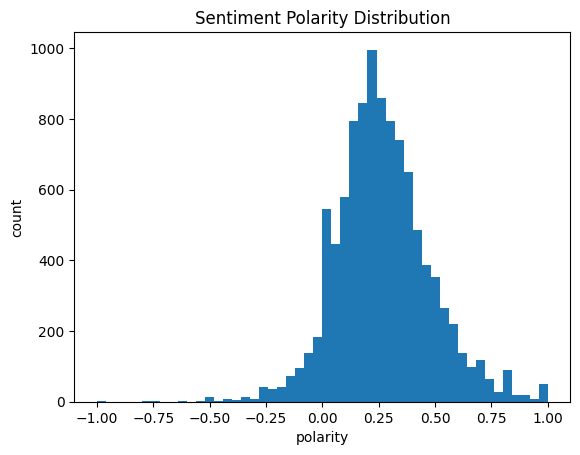

In [46]:
reviews['polarity'].plot(
    kind='hist',
    bins=50,
    xlabel='polarity',
    ylabel='count',
    title='Sentiment Polarity Distribution')
plt.show()

**Insights:**

1. We have a lot of positive polarities compared to the negative polarities

2. This polarity distributions assures the number of positive reviews we had

3. We can say that this polarity is a normally distributed but not standard normal


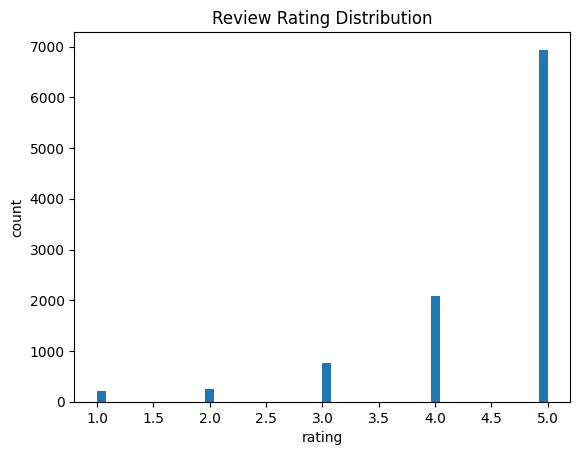

In [47]:
reviews['overall'].plot(
    kind='hist',
    bins=50,
    xlabel='rating',
    ylabel='count',
    title='Review Rating Distribution')
plt.show()

**We have a highest count of 5 ratings(nearly 7k) followed by 4,3,2,1. It's linear in nature**

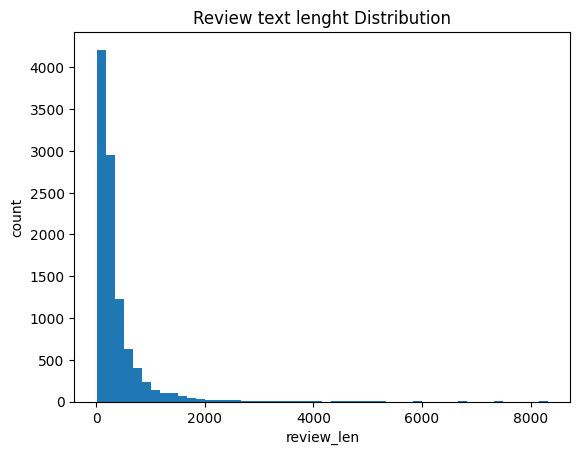

In [48]:
reviews['review_len'].plot(
    kind='hist',
    bins=50,
    xlabel='review_len',
    ylabel='count',
    title='Review text lenght Distribution')
plt.show()

**We have a right skewed distribution where most of the lengths falls between 0-1000**

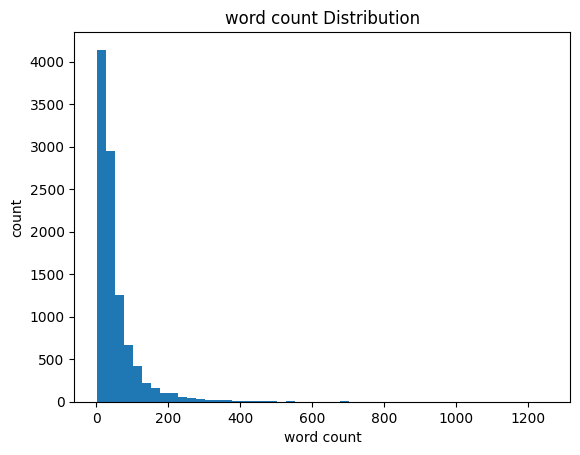

In [49]:
reviews['word_count'].plot(
    kind='hist',
    bins=50,
    xlabel='word count',
    ylabel='count',
    title='word count Distribution')
plt.show()

In [50]:
reviews.columns

Index(['reviewerID', 'asin', 'reviewerName', 'overall', 'review_combined',
       'sentiments', 'helpful_rate', 'polarity', 'review_len', 'word_count'],
      dtype='object')

**We have a right skewed distribution with most of the words falling between 0-200 in a a review**

In [51]:
#Filtering data
review_pos = reviews[reviews["sentiments"]=='Positive'].dropna()
review_neu = reviews[reviews["sentiments"]=='Neutral'].dropna()
review_neg = reviews[reviews["sentiments"]=='Negative'].dropna()

In [52]:
review_pos["review_combined"]

0        Not much write here, exactly supposed to. filt...
1        The product exactly quite affordable.I realize...
2        The primary job device block breath would othe...
3        Nice windscreen protects MXL mic prevents pops...
4        This pop filter great. It looks performs like ...
                               ...                        
10256                Great, expected. Thank all.Five Stars
10257    I've thinking trying Nanoweb strings while, I ...
10258    I tried coated strings past including Elixirs)...
10259    Well, MADE Elixir DEVELOPED Taylor Guitars ......
10260    These strings really quite good, I call perfec...
Name: review_combined, Length: 9022, dtype: object

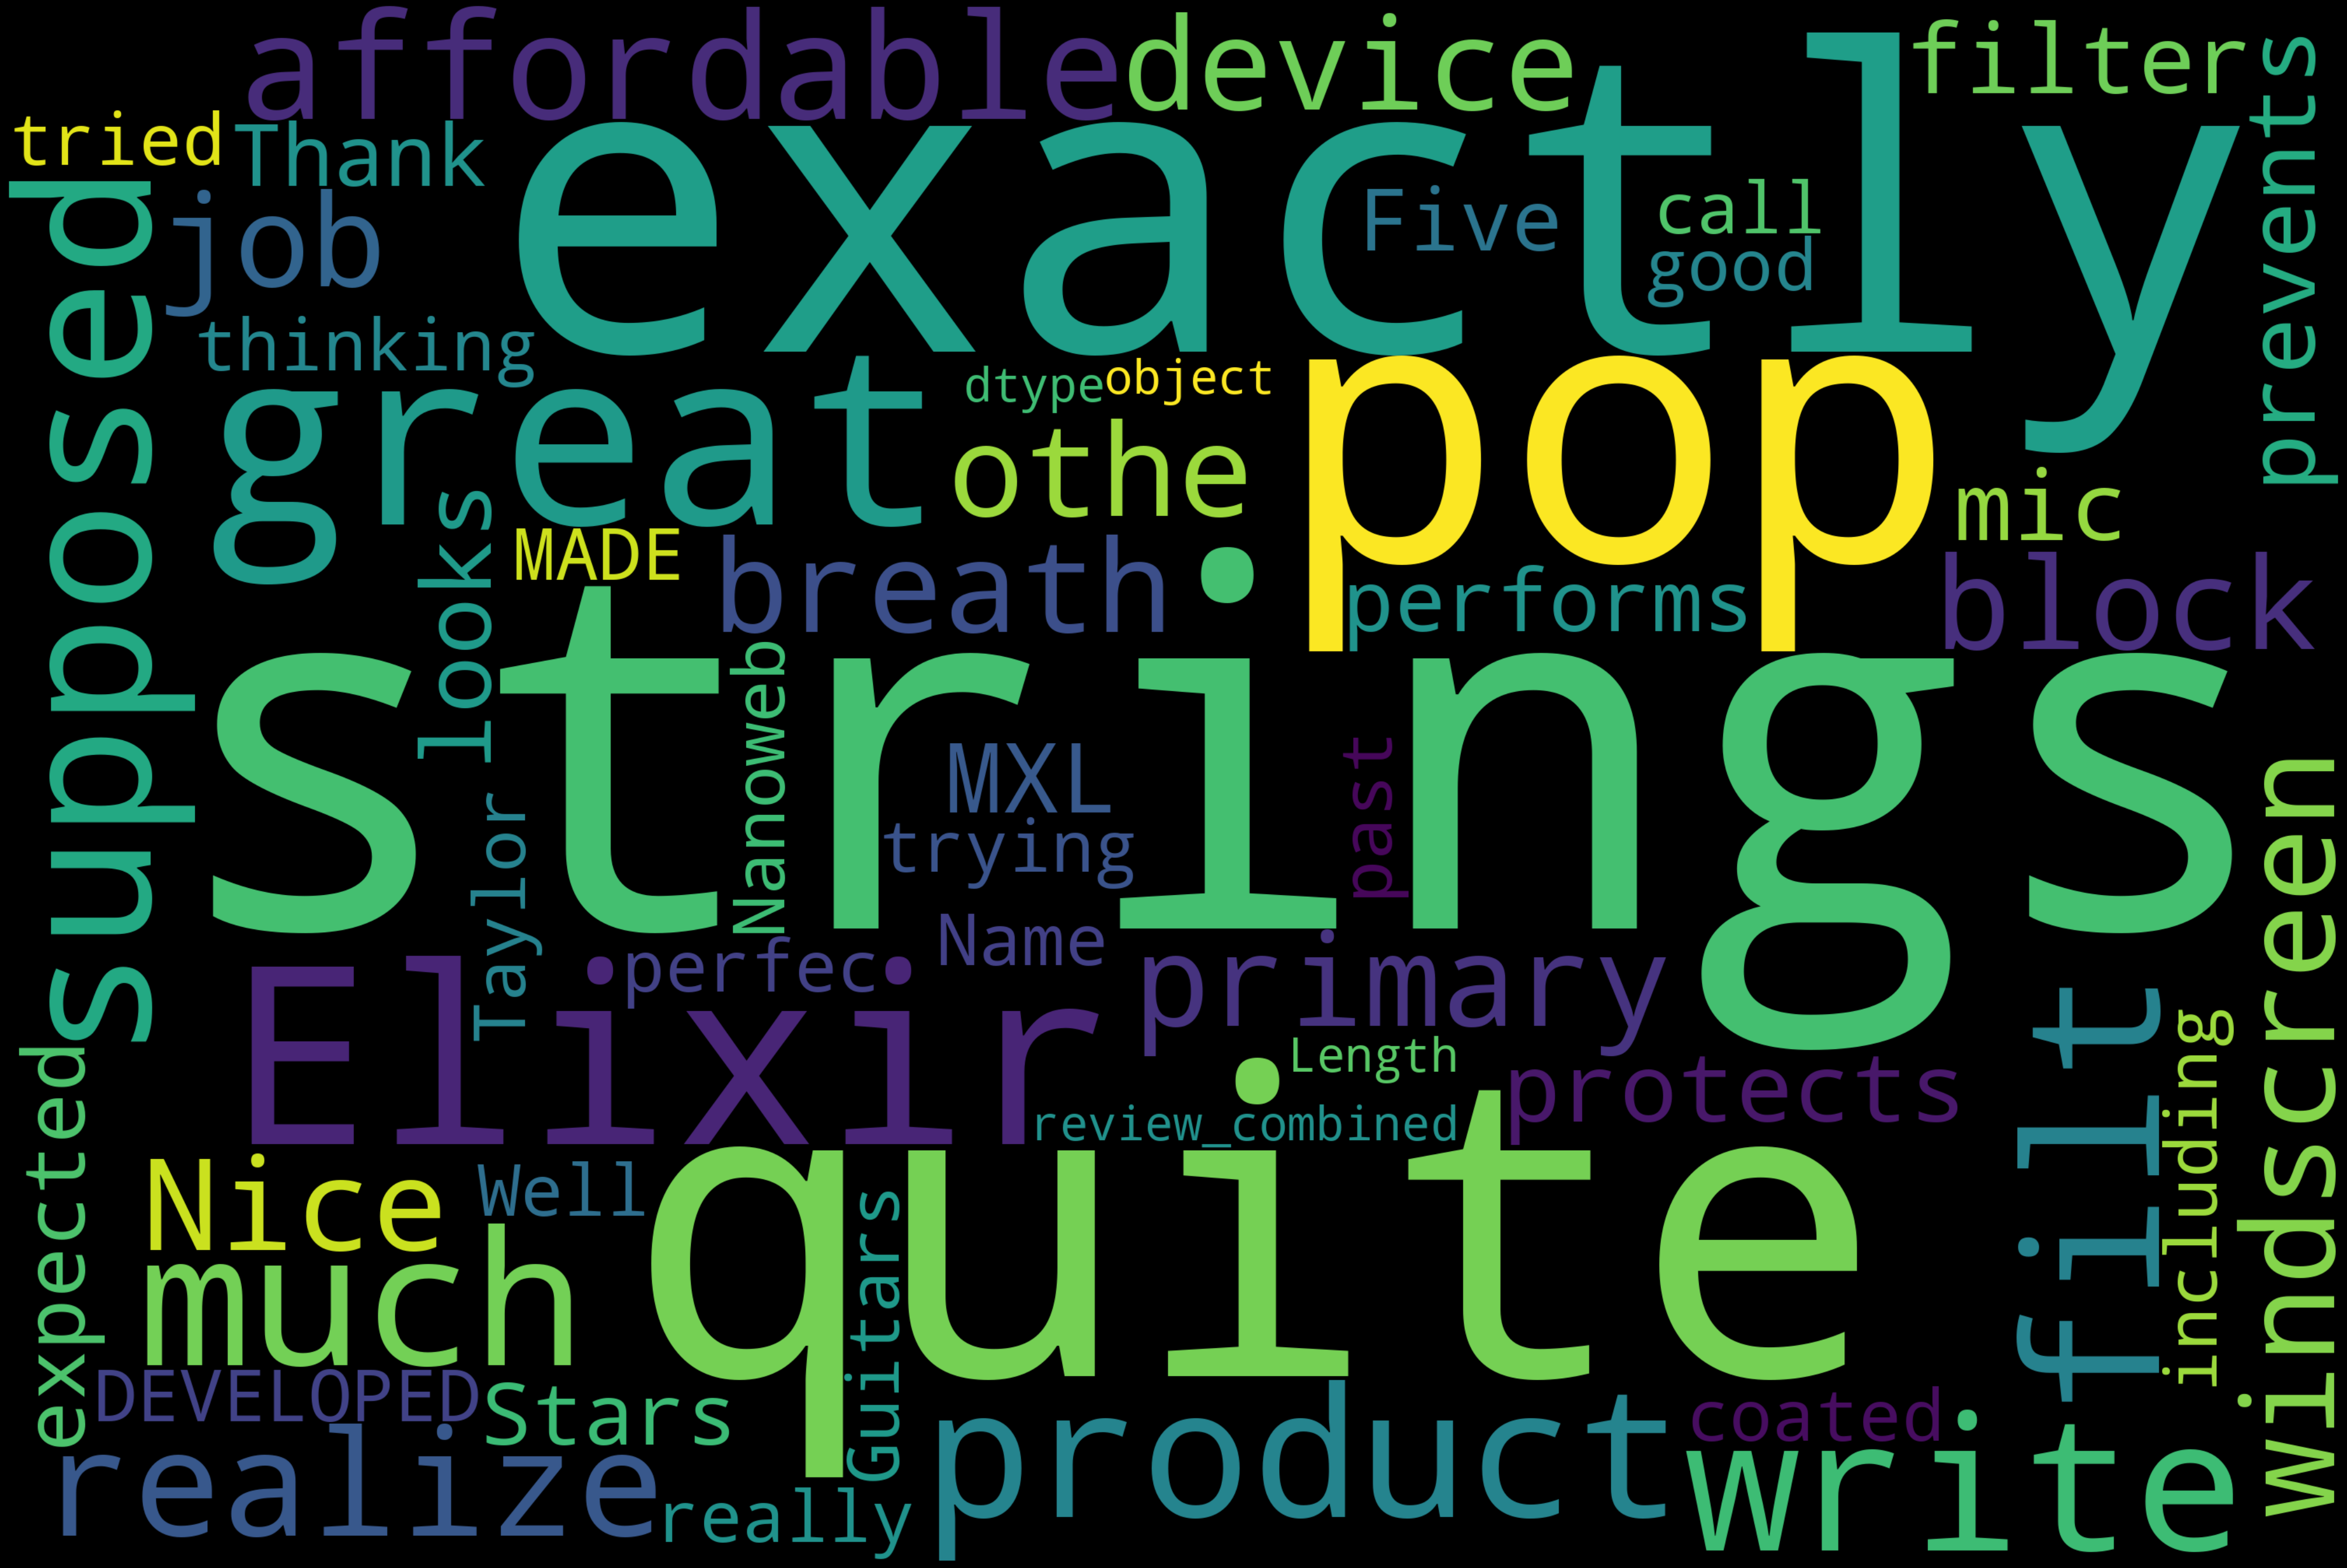

In [53]:
text = review_pos["review_combined"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
     figsize = (40, 30),
     facecolor = 'k',
     edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

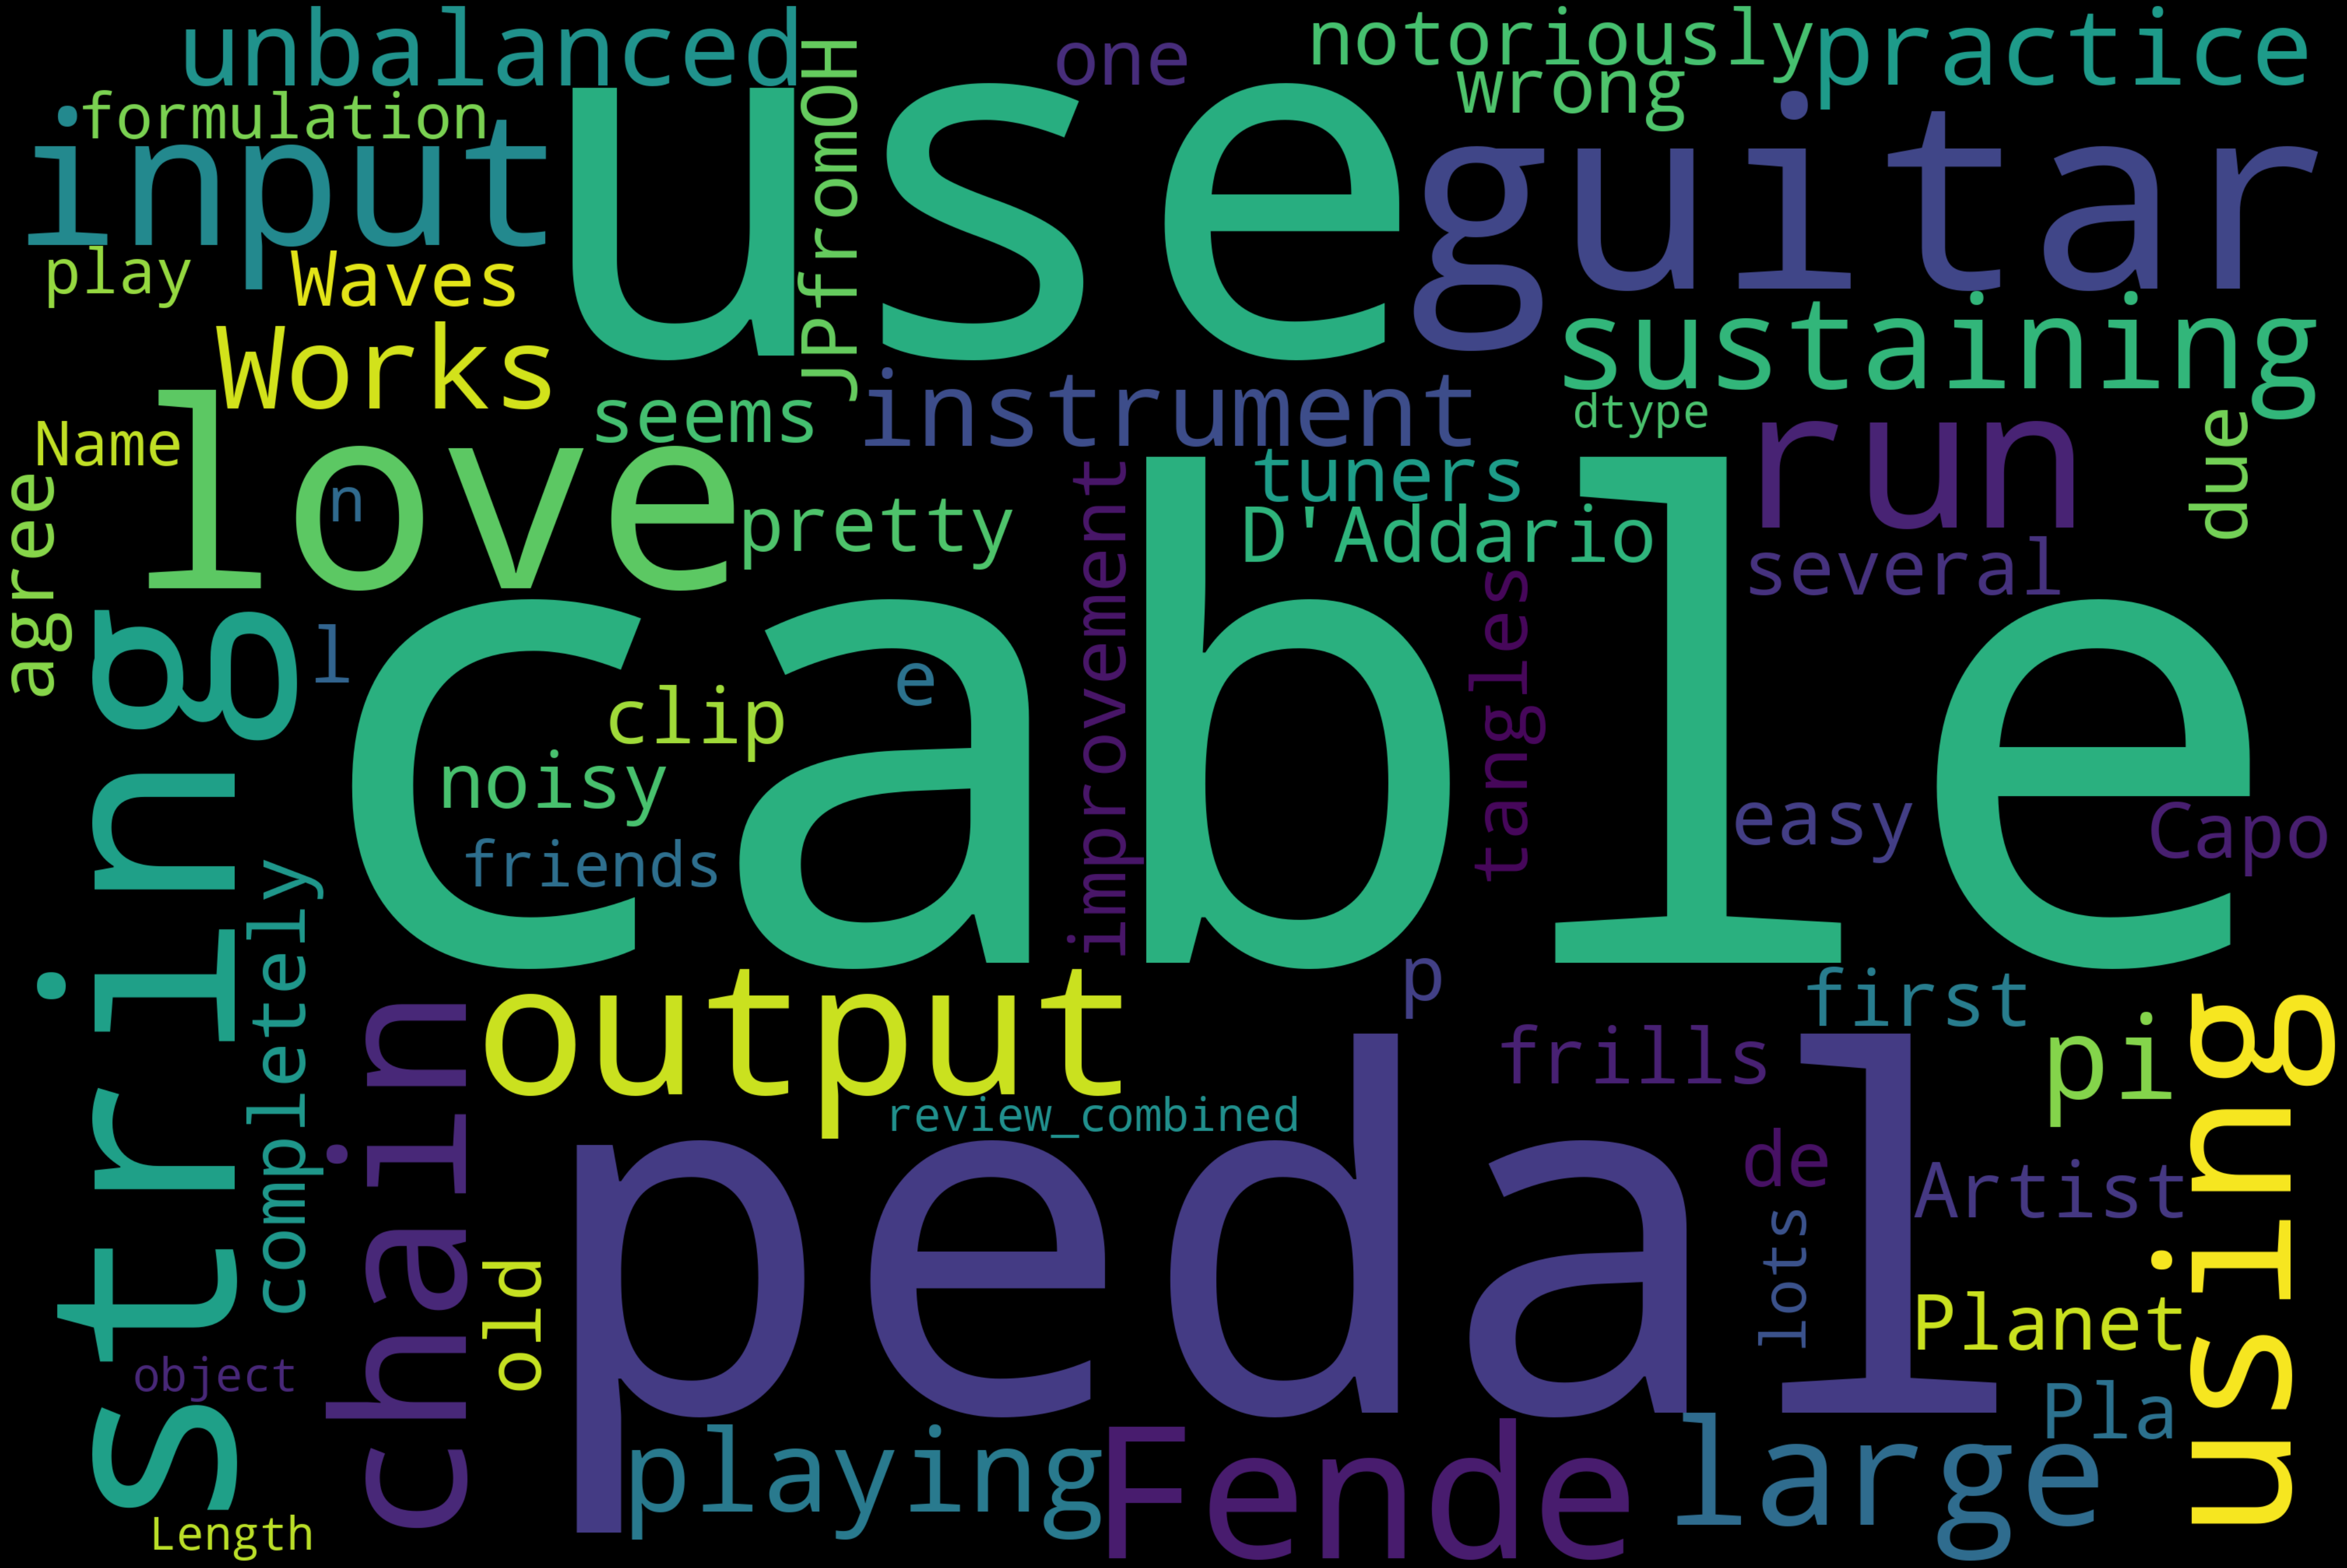

In [54]:
text = review_neu["review_combined"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
     figsize = (40, 30),
     facecolor = 'k',
     edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

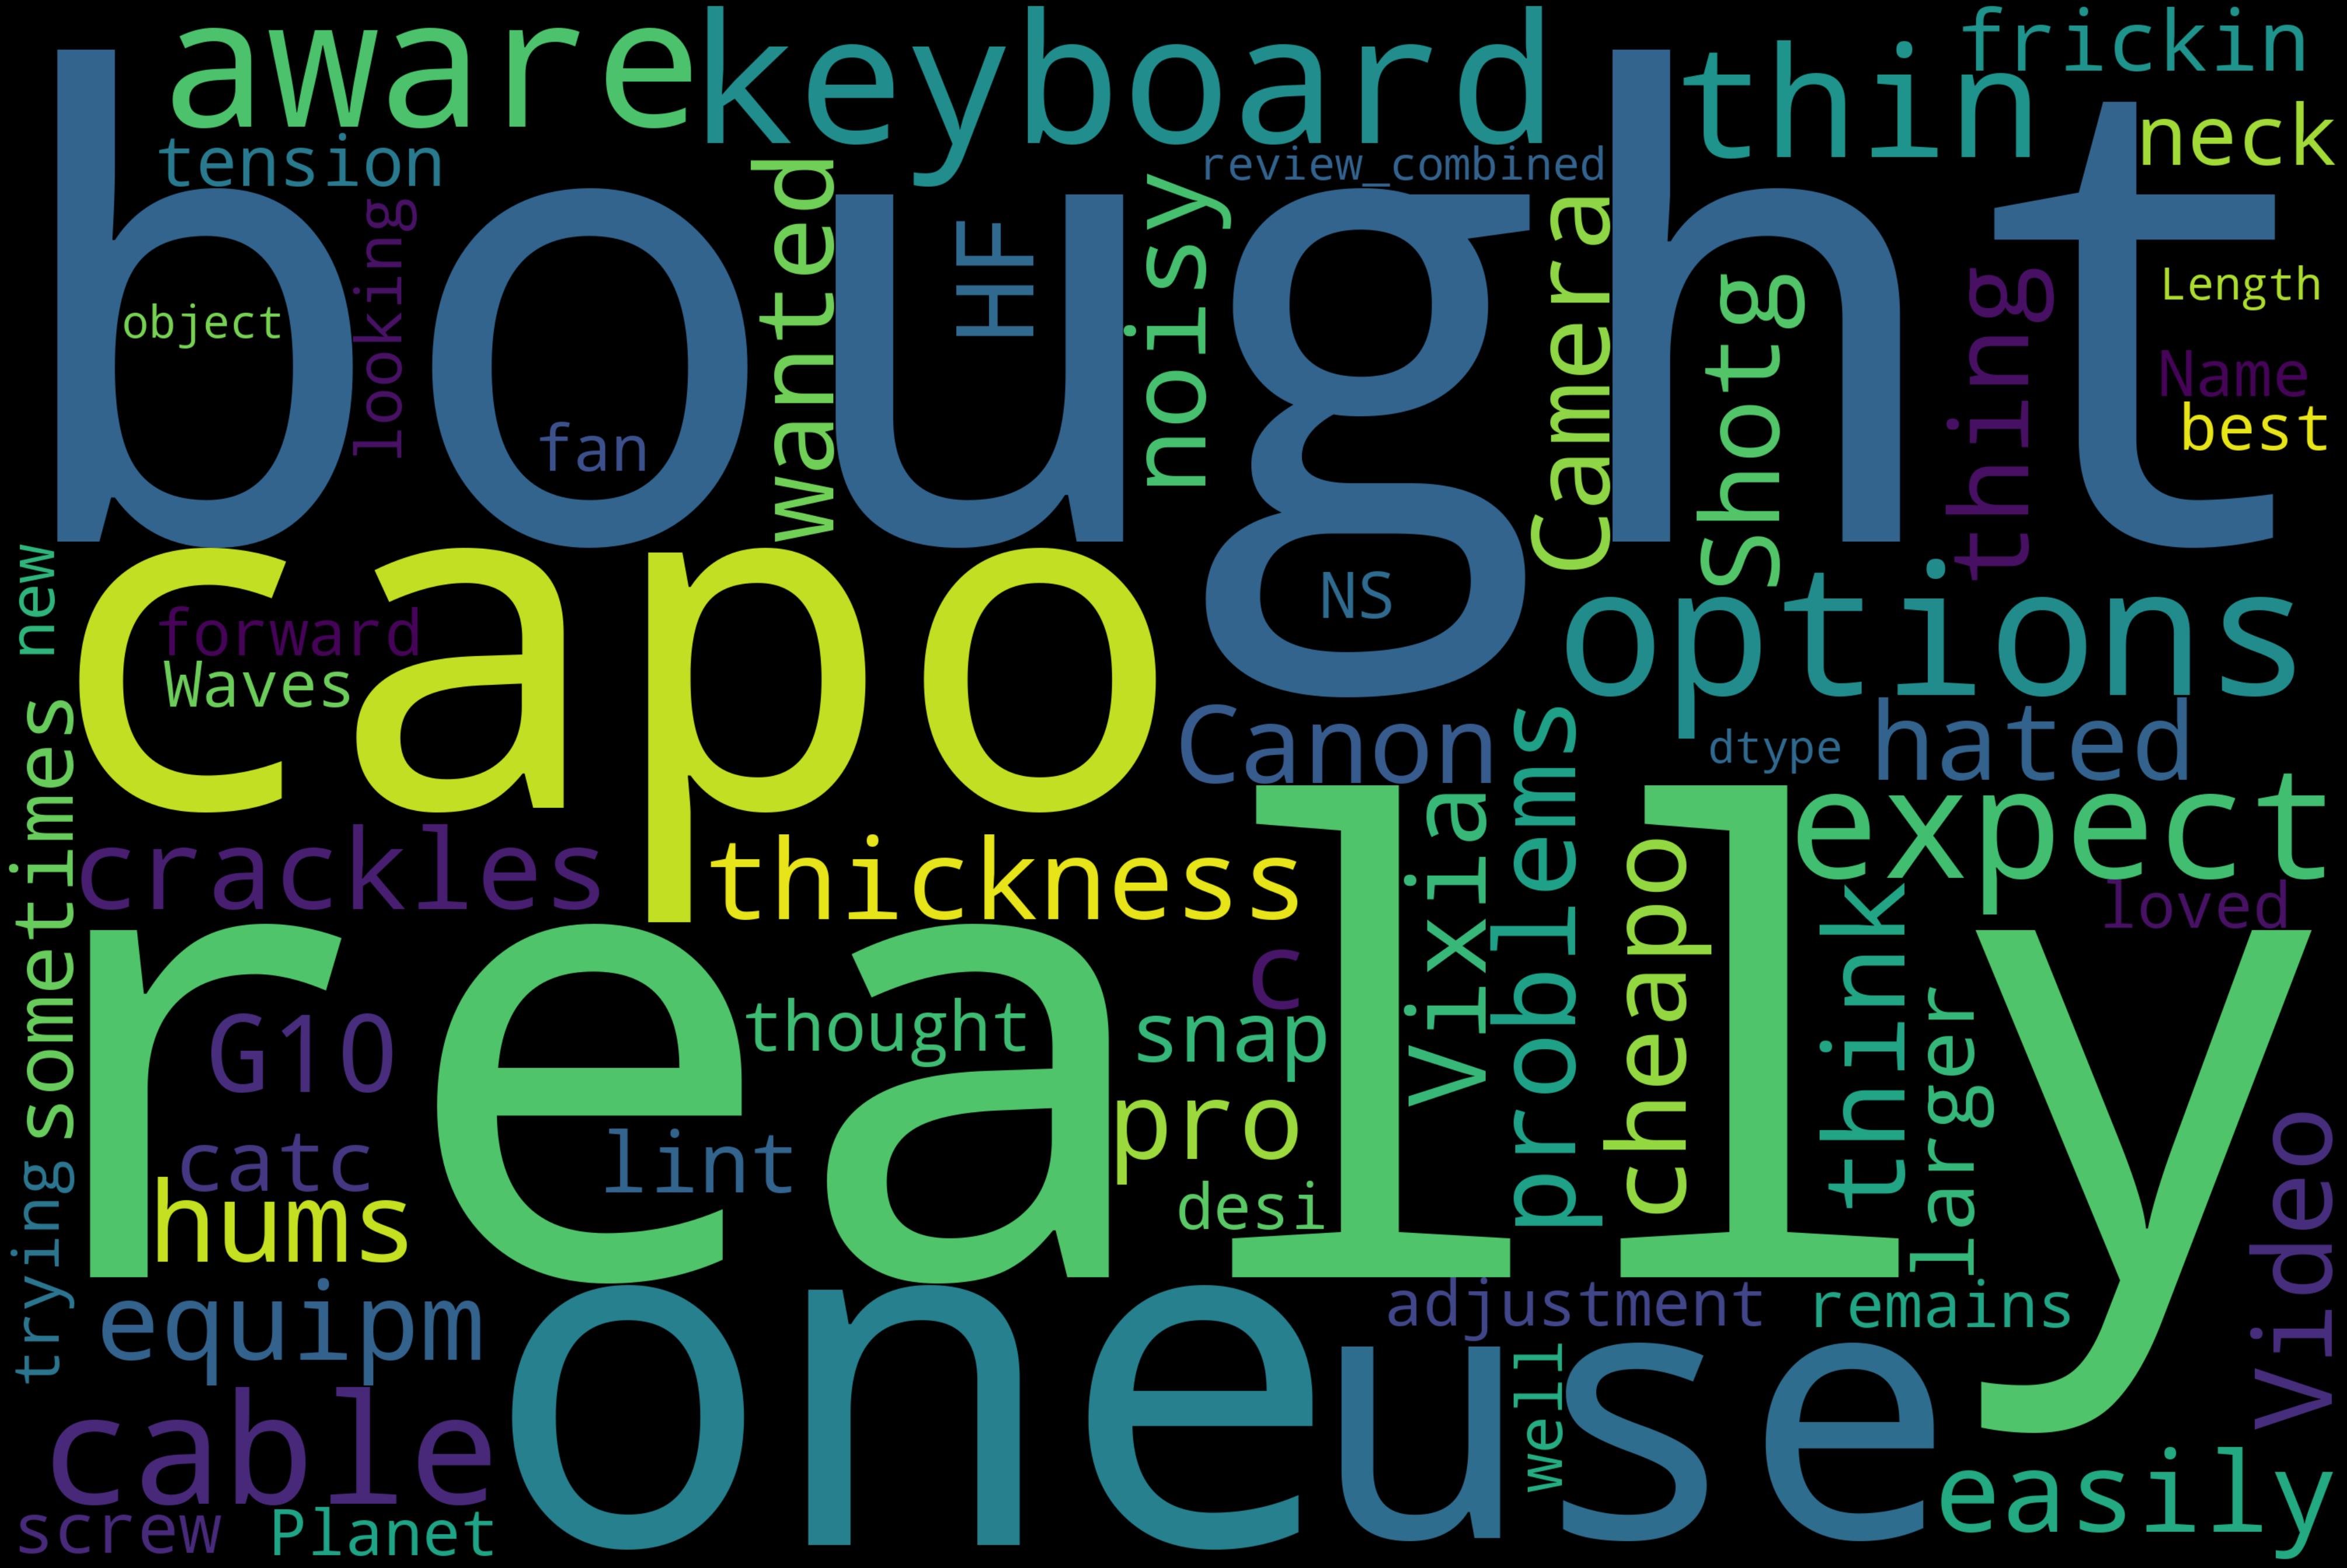

In [55]:
text = review_neg["review_combined"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
     figsize = (40, 30),
     facecolor = 'k',
     edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### **Extracting Features from Cleaned reviews:**

Before we build the model for our sentiment analysis, it is required to convert the review texts into vector formation as computer cannot understand words and their sentiment. In this project, we are going to use TF-TDF method to convert the texts

In [56]:
from sklearn import preprocessing

In [57]:
label_encoder= preprocessing.LabelEncoder()

In [58]:
reviews["sentiments"]=label_encoder.fit_transform(reviews["sentiments"])

In [59]:
reviews["sentiments"].value_counts()

sentiments
2    9022
1     772
0     467
Name: count, dtype: int64

In [60]:
review_feature = reviews.copy()

In [61]:
review_feature= review_feature[["review_combined"]].reset_index(drop=True)

In [62]:
review_feature.head()

review_combined
0  Not much write here, exactly supposed to. filt...
1  The product exactly quite affordable.I realize...
2  The primary job device block breath would othe...
3  Nice windscreen protects MXL mic prevents pops...
4  This pop filter great. It looks performs like ...

In [63]:
ps = PorterStemmer()

corpus=[]
for i in range(0,len(review_feature)):
  review= re.sub("[^a-zA-Z]", " ",review_feature["review_combined"][i])
  review=review.split()
  review= [ps.stem(word) for word in review if not word in stop_words]
  review= " ".join(review)
  corpus.append(review)

In [64]:
corpus[3]

'nice windscreen protect mxl mic prevent pop onli thing gooseneck margin abl hold screen posit requir care posit clamp avoid sag good windscreen for the money'

In [65]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))

# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_feature['review_combined'])

In [66]:
X.shape

(10261, 5000)

**As we have considered 5000 words, we can confirm that we have 5000 columns from the shape.**

In [67]:
y= reviews["sentiments"]

**Handling Imbalance target feature-SMOTE**

*   In our target feature, we noticed that we got a lot of positive sentiments compared to negative and neutral. So it is crucial to balanced the classes in such situatio. Here I use SMOTE(Synthetic Minority Oversampling Technique) to balance out the imbalanced dataset problem.It aims to balance class distribution by randomly increasing minority class examples by replicating them.
*  SMOTE synthesises new minority instances between existing minority instances. It generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.

In [68]:
y.shape

(10261,)

In [69]:
from imblearn.over_sampling import SMOTE

In [70]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [71]:
print(X_res.shape)
print(y_res.shape)


(27066, 5000)
(27066,)


In [72]:
print(Counter(y))
print(Counter(y_res))

Counter({2: 9022, 1: 772, 0: 467})
Counter({2: 9022, 1: 9022, 0: 9022})


In [76]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

### **MODELING**

### **1. LOGISTIC REGRESSION**

In [77]:
lr=LogisticRegression(penalty="l2",max_iter=500,C=1,random_state=0)
lr.fit(X_train,y_train)
lr_y_pred= lr.predict(X_test)
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2326
           1       0.83      0.95      0.89      2232
           2       0.96      0.80      0.87      2209

    accuracy                           0.90      6767
   macro avg       0.90      0.90      0.90      6767
weighted avg       0.90      0.90      0.90      6767



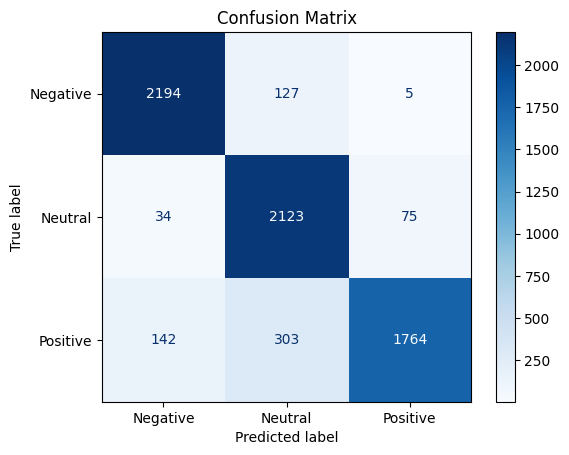

In [78]:
cm = metrics.confusion_matrix(y_test, lr_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### **2. Multinominal Naive Bayes**

In [79]:
mnb=MultinomialNB()
mnb.fit(X_train,y_train)
mnb_y_pred= mnb.predict(X_test)
print(classification_report(y_test, mnb_y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2326
           1       0.84      0.90      0.87      2232
           2       0.89      0.76      0.82      2209

    accuracy                           0.87      6767
   macro avg       0.87      0.87      0.87      6767
weighted avg       0.87      0.87      0.87      6767



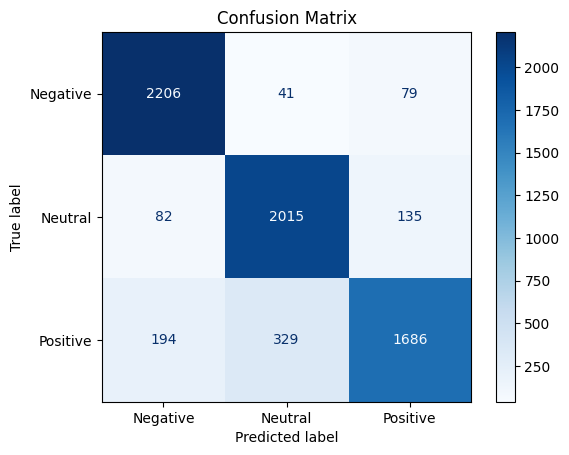

In [80]:
cm = metrics.confusion_matrix(y_test, mnb_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



*   We have got 89% accuracy in logisticregression model and 87% in multinomial naive bayes. That ain't bad. But for classification problems we need to get confusion matrix and check f1 score rather than accuracy
*   Since predicting both positive,negative and neutral reviews are important we are considering.We got a pretty good f1 score. As we see it got a good score across all classes classified in logistic regression model



## **Conclusion:**

We have done a pretty neat job on classifying all the classes starting from splitting the sentiments based on overall score,text cleaning, customize the stopwords list based on requirement and finally handling imbalance with smote. Here are few insights from the notebook.

Most of our neutral reviews were actual critic of product from the buyers, so amazon can consider these as feedback and give them to the seller to help them improve their products
Most of the reviews in this dataset were about string instruments such as guitar.

Balancing the dataset got me a very fruitful accuracy score. Without balancing, I got good precision but very bad recall and inturn affected my f1 score. So balancing the target feature is important

In sentiment analysis, we should concentrate on our f1 score where we got an average of 89% so we did a pretty good job.



****